Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 87s 8s/step - accuracy: 0.6172 - loss: 29.0532 - val_accuracy: 0.7248 - val_loss: 0.6051
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.7015 - loss: 0.6106 - val_accuracy: 0.7248 - val_loss: 0.4653
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.7100 - loss: 0.5366 - val_accuracy: 0.7248 - val_loss: 0.4372
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 86s 8s/step - accuracy: 0.7302 - loss: 0.4725 - val_accuracy: 0.8245 - val_loss: 0.4085
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.8050 - loss: 0.4408 - val_accuracy: 0.8380 - val_loss: 0.3884
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 189s 18s/step - accuracy: 0.8252 - loss: 0.4024 - val_accuracy: 0.8366 - val_loss: 0.3634
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 219s 19s/step - accuracy: 0.8270 - loss: 0.3991 - val_accuracy: 0.8295 - val_loss: 0.3828
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.8306 - loss: 0.3904 - val_accuracy: 0.8416 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
Landslide mask saved at: E:/shashank/landslides/predictions/landslidemask.jpg
Landslide polygons saved at: E:/shashank/landslides/predictions/landslide_polygons.geojson


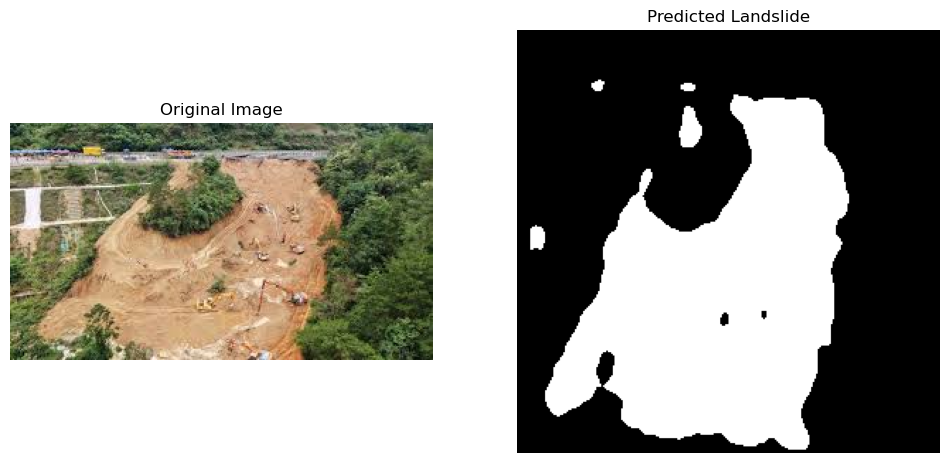

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os
import numpy as np
import rasterio
import cv2


def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Load .tif images and masks
def load_tif_data(image_dir, mask_dir, image_size=(256, 256)):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        if not filename.endswith(".jpg"):
            continue 

        img_path = os.path.join(image_dir, filename)
        with rasterio.open(img_path) as src:
            img = src.read().transpose(1, 2, 0) 
            img = cv2.resize(img, image_size)  
            img = img.astype(np.float32) / 255.0  

            if img.shape[-1] > 3:  
                img = img[:, :, :3]  
            elif img.shape[-1] == 1:
                img = np.repeat(img, 3, axis=-1)  

            images.append(img)

        # Load corresponding mask
        mask_filename = filename.replace(".jpg", "_mask.png")
        mask_path = os.path.join(mask_dir, mask_filename)

        with rasterio.open(mask_path) as src:
            mask = src.read(1)  
            mask = cv2.resize(mask, image_size)
            mask = (mask > 0).astype(np.uint8)  
            mask = np.expand_dims(mask, axis=-1)  

        masks.append(mask)

    return np.array(images), np.array(masks)

# Load TIF data
image_dir = "E:/shashank/landslides/images"
mask_dir = "E:/shashank/landslides/images/masks"
X, y = load_tif_data(image_dir, mask_dir)

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
input_size = (256, 256, 3)
model = unet_model(input_size=input_size)
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_val, y_val))

# Save the model
model.save("unet_landslide_detector_tif.h5")


import tensorflow as tf
import numpy as np
import rasterio
import cv2
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon

# Load Trained Model
MODEL_PATH = "unet_landslide_detector_tif.h5"
model = tf.keras.models.load_model(MODEL_PATH)

# Predict Landslide Function
def predict_landslide(image_path, model):
    with rasterio.open(image_path) as src:
        img = src.read([1, 2, 3])  
        img = np.moveaxis(img, 0, -1)  
        img = cv2.resize(img, (256, 256))  
        img = img.astype(np.float32) / 255.0  
        img = np.expand_dims(img, axis=0) 

    # Predict
    pred = model.predict(img)[0, :, :, 0]  
    pred = (pred > 0.5).astype(np.uint8)  
    return pred

# Convert Prediction to Polygon
def mask_to_polygon(mask, transform):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        if len(contour) > 2:  # Ignore small objects
            coords = [tuple(transform * (pt[0][0], pt[0][1])) for pt in contour]
            polygons.append(Polygon(coords))
    return gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")

# Paths
PREDICT_IMG_PATH = "E:/shashank/landslides/predictions/landslide.jpg"
PREDICTION_SAVE_PATH = "E:/shashank/landslides/predictions/landslidemask.jpg"
OUTPUT_POLYGON_PATH = "E:/shashank/landslides/predictions/landslide_polygons.geojson"

# Predict
predicted_mask = predict_landslide(PREDICT_IMG_PATH, model)

# Save Predicted Mask as TIF
with rasterio.open(PREDICT_IMG_PATH) as src:
    meta = src.meta.copy()
    meta.update(dtype=rasterio.uint8, count=1)
    with rasterio.open(PREDICTION_SAVE_PATH, "w", **meta) as dst:
        dst.write(predicted_mask, 1)

# Convert Mask to Polygon and Save
with rasterio.open(PREDICT_IMG_PATH) as src:
    landslide_polygons = mask_to_polygon(predicted_mask, src.transform)
landslide_polygons.to_file(OUTPUT_POLYGON_PATH)

print("Landslide mask saved at:", PREDICTION_SAVE_PATH)
print("Landslide polygons saved at:", OUTPUT_POLYGON_PATH)

# **Visualize Prediction**
with rasterio.open(PREDICT_IMG_PATH) as src:
    img = src.read([1, 2, 3])  # Read first 3 bands
    img = np.moveaxis(img, 0, -1)  # Convert to (H, W, C)

plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

# Predicted Mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Predicted Landslide")
plt.axis("off")

plt.show()




In [15]:
pip install pystac-client odc-stac

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for odc-stac from https://files.pythonhosted.org/packages/4b/0c/addcc81cf8be8f17ce623c829a405e8cc9c4a235365bd7c9bcf891ccaea2/odc_stac-0.3.11-py3-none-any.whl.metadata
  Obtaining dependency information for odc-geo>=0.4.7 from https://files.pythonhosted.org/packages/4b/25/771bca8387587f2eda3a2cef47afb783e0bece01d4c58fff723d2b996ba5/odc_geo-0.4.9.post0-py3-none-any.whl.metadata
  Using cached odc_geo-0.4.9.post0-py3-none-any.whl.metadata (5.5 kB)
   ---------------------------------------- 0.0/89.4 kB ? eta -:--:--
   ------------- -------------------------- 30.7/89.4 kB 640.0 kB/s eta 0:00:01
   --------------------------- ------------ 61.4/89.4 kB 656.4 kB/s eta 0:00:01
   ---------------------------------------- 89.4/89.4 kB 719.4 kB/s eta 0:00:00
Using cached odc_geo-0.4.9.post0-py3-none-any.whl (153 kB)
Note: you may need to restart the kernel to use updated packages.
